# Введение в нейронные сети
## Урок 3. TensorFlow

1. Попробуйте улучшить работу нейронной сети (разобранную на уроке), обучавшейся на датасет Fashion-MNIST. Напишите в комментариях к уроку, какого результата вы добились от нейросети и что помогло улучшить её точность
2. Поработайте с документацией TensorFlow 2. Попробуйте найти полезные команды TensorFlow, неразобранные на уроке

Напишите в комментариях к уроку, какого результата вы добились от нейросети и что
помогло улучшить её точность

## Установка и импорт зависимостей

In [ ]:
!pip install -U tensorflow_datasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from __future__ import absolute_import, division, print_function, unicode_literals

# импортируем TensorFlow и набор данных TensorFlow
import tensorflow as tf
import tensorflow_datasets as tfds

# вспомогательные библиотеки
import math
import numpy as np
import matplotlib.pyplot as plt

# Улучшим отображение прогрессбара
import tqdm
import tqdm.auto
tqdm.tqdm = tqdm.auto.tqdm

print(tf.__version__)

tf.compat.v1.enable_eager_execution()

2.12.0


Eager execution обеспечивает императивный интерфейс для TensorFlow. При включенном быстром выполнении функции TensorFlow выполняют операции немедленно (в отличие от добавления к графу, которое будет выполнено позже в tf.compat.v1.Session) и возвращают конкретные значения (в отличие от символических ссылок на узел в вычислительном графе).

## Импортируем набор данных Fashion MNIST

Используется набор данных Fashion MNIST, который содержит 70 000 изображений элементов одежды в 10 категориях в градациях серого. Изображения содержат элементы одежды в низком разрешении (28х28 пикселей), как показано ниже:

![alt text](https://tensorflow.org/images/fashion-mnist-sprite.png)

In [ ]:
dataset, metadata = tfds.load('fashion_mnist', as_supervised=True, with_info=True)
train_dataset, test_dataset = dataset['train'], dataset['test']

Здесь 60 000 изображений используются для обучения сети и 10 000 изображений для оценки того, насколько точно сеть научилась классифицировать изображения.
*   Модель обучается на наборе данных из `train_dataset`
*   Модель тестируется на наборе данных из `test_dataset`

Изображения представляют собой двумерные массивы 28х28, где значения в каждой ячейке могут быть в интервале `[0, 255]`. Метки - массив целых чисел, где каждое значение в интервале `[0, 9]`. Эти метки соответствуют выходному классу изображения следующим образом:

<table>
  <tr>
    <th>Метка</th>
    <th>Класс</th> 
  </tr>
  <tr>
    <td>0</td>
    <td>Футболка / топ</td> 
  </tr>
  <tr>
    <td>1</td>
    <td>Шорты</td> 
  </tr>
    <tr>
    <td>2</td>
    <td>Свитер</td> 
  </tr>
    <tr>
    <td>3</td>
    <td>Платье</td> 
  </tr>
    <tr>
    <td>4</td>
    <td>Плащ</td> 
  </tr>
    <tr>
    <td>5</td>
    <td>Сандали</td> 
  </tr>
    <tr>
    <td>6</td>
    <td>Рубашка</td> 
  </tr>
    <tr>
    <td>7</td>
    <td>Кроссовок</td> 
  </tr>
    <tr>
    <td>8</td>
    <td>Сумка</td> 
  </tr>
    <tr>
    <td>9</td>
    <td>Ботинок</td> 
  </tr>
</table>

Каждое изображение относится к одной метке. Так как наименования классов не содержатся в исходном наборе данных - сохраняем их для дальнейшего использования, когда будем отрисовывать изображения:

In [ ]:
class_names = ['Футболка / топ', "Шорты", "Свитер", "Платье",
              "Плащ", "Сандали", "Рубашка", "Кроссовок", "Сумка",
              "Ботинок"]

In [ ]:
num_train_examples = metadata.splits['train'].num_examples
num_test_examples = metadata.splits['test'].num_examples
print('Количество тренировочных экземпляров: {}'.format(num_train_examples))
print('Количество тестовых экземпляров: {}'.format(num_test_examples))

Количество тренировочных экземпляров: 60000
Количество тестовых экземпляров: 10000


## Нормализуем данные

Значение каждого пикселя в изображении находится в интервале [0,255]. Для того, чтобы модель работала корректно эти значения необходимо нормализовать - привести к значениям в интервале [0,1]

In [ ]:
def normalize(images, labels):
  images = tf.cast(images, tf.float32)
  images /= 255
  return images, labels

def mirror(images, labels):
  return tf.image.flip_up_down(images), labels

# метод map применяет функцию нормализации к каждому элементу в массиве
# тестовых и тренировочных наборах данных
train_dataset = train_dataset.map(normalize)
test_dataset = test_dataset.map(normalize)

## Изучаем обработанные данные

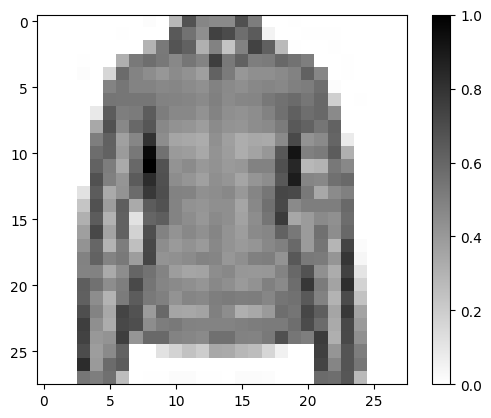

In [ ]:
# Берём единственное изображение и удаляем из него цветовую составляющую
# посредством метода reshape()
for image, label in test_dataset.take(1):
  break;
image = image.numpy().reshape((28, 28))

# отрисовываем изображение
plt.figure()
plt.imshow(image, cmap=plt.cm.binary)
plt.colorbar()
plt.grid(False)
plt.show()

Отобразим первые 25 изображений из тренировочного набора данных и под каждым изображением укажем к какому классу оно относится.

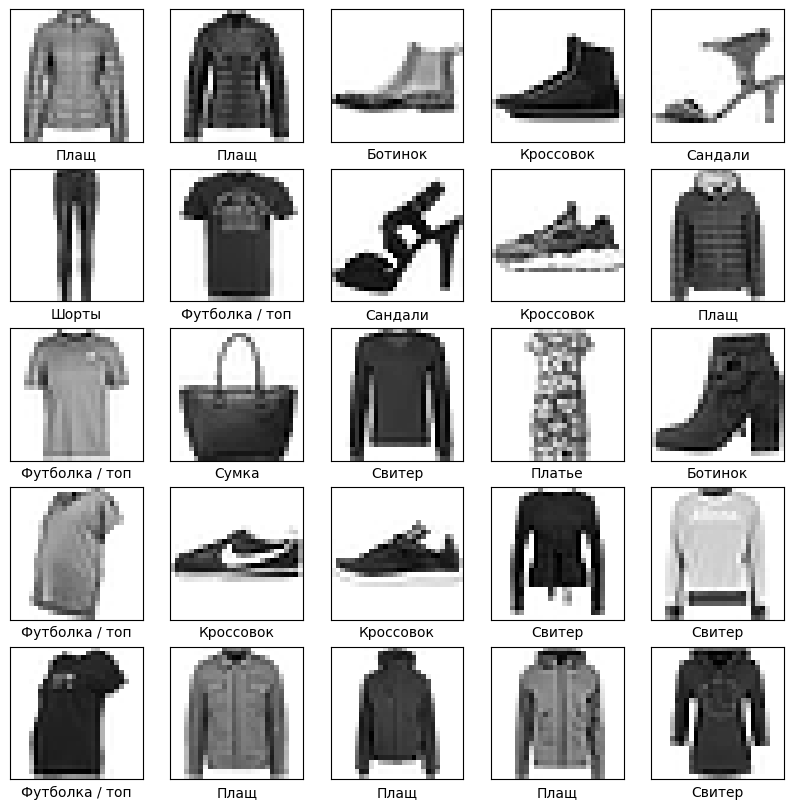

In [ ]:
plt.figure(figsize=(10,10))
i = 0
for (image, label) in test_dataset.take(25):
  image = image.numpy().reshape((28,28))
  plt.subplot(5,5,i+1)
  plt.xticks([])
  plt.yticks([])
  plt.grid(False)
  plt.imshow(image, cmap=plt.cm.binary)
  plt.xlabel(class_names[label])
  i += 1
plt.show()

## Настраиваем слои

In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), padding='same', activation=tf.nn.relu,
                           input_shape=(28, 28, 1)),
    tf.keras.layers.MaxPooling2D((2, 2), strides=2),
    tf.keras.layers.Conv2D(64, (3,3), padding='same', activation=tf.nn.relu),
    tf.keras.layers.MaxPooling2D((2, 2), strides=2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation=tf.nn.relu),
    tf.keras.layers.Dense(10, activation=tf.nn.softmax)
])

Сеть состоит из трёх слоёв:

* **входного** `tf.keras.layers.Flatten` - этот слой преобразует изображения размером 28х28 пикселей в 1D-массив размером 784 (28 * 28). На этом слое у нас нет никаких параметров для обучения, так как этот слой занимается только преобразованием входных данных.

* **скрытый слой** `tf.keras.layers.Dense` - плотносвязный слой из 128 нейронов. Каждый нейрон (узел) принимает на вход все 784 значения с предыдущего слоя, изменяет входные значения согласно внутренним весам и смещениям во время тренировки и возвращает единственное значение на следующий слой.

* **выходной слой** `ts.keras.layers.Dense` - `softmax`-слой состоит из 10 нейронов, каждый из которых представляет определённый класс элемента одежды. Как и в предыдущем слое, каждый нейрон принимает на вход значения всех 128 нейронов предыдущего слоя. Веса и смещения каждого нейрона на этом слое изменяются при обучении таким образом, чтобы результатирующее значение было в интервале `[0,1]` и представляло собой вероятность того, что изображение относится  к этому классу. Сумма всех выходных значений 10 нейронов равна 1.

## Компилируем модель

In [ ]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

* *функция оптимизации* - агоритм "подгонки" внутренних параметров (весов и смещений) модели для минимизации функции потерь;
* *функция потерь* - алгоритм измерения того, насколько далеко находится желаемое значение от спрогнозированного. 
* *метрики* - используются для мониторинга процесса тренировки и тестирования. Пример ниже использует такую метрику как `точность`, процент изображений, которые были корректно классифицированы.

## Тренируем модель

In [ ]:
BATCH_SIZE = 32
train_dataset = train_dataset.repeat().shuffle(num_train_examples).batch(BATCH_SIZE)
test_dataset = test_dataset.batch(BATCH_SIZE)

1. Метод `dataset.batch(32)` сообщает методу тренировки `model.fit` использовать блоки по 32 изображения и метки при обновлении внутренних переменных модели.
2. Повторяем бесконечное количество раз набор входных данных используя метод `dataset.repeat()` (параметр `epochs`, который описан ниже, определяет количество всех обучающих итераций для выполнения).
3. Метод `dataset.shuffle(60000)` перемешивает все изображения для того, чтобы на обучение нашей модели не влиял порядок подачи входных данных.

In [ ]:
model.fit(train_dataset, epochs=5, steps_per_epoch=math.ceil(num_train_examples/BATCH_SIZE))

Epoch 1/5


/usr/local/lib/python3.10/dist-packages/keras/backend.py:5612: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


1875/1875 [==============================] - 125s 59ms/step - loss: 0.4015 - accuracy: 0.8559
Epoch 2/5
1875/1875 [==============================] - 98s 52ms/step - loss: 0.2643 - accuracy: 0.9029
Epoch 3/5
1875/1875 [==============================] - 95s 51ms/step - loss: 0.2219 - accuracy: 0.9189
Epoch 4/5
1875/1875 [==============================] - 96s 51ms/step - loss: 0.1908 - accuracy: 0.9299
Epoch 5/5
1875/1875 [==============================] - 100s 53ms/step - loss: 0.1633 - accuracy: 0.9390


По мере обучения модели отображаются показатели потерь и точности. Эта модель достигает точности около 0,93 (или 93%) на обучающих данных.

Тренировка происходит посредством вызова метода `model.fit`:
1. Отправляет `train_dataset` на вход модели.
2. Модель учится сопоставлять входное изображение с меткой.
3. Параметр `epochs=5` ограничивает количество тренировок до 5 полных обучающих итераций по набору данных, что в итоге даёт нам тренировку на 5 * 60000 = 300 000 примерах.

## Оценка точности

In [ ]:
test_loss, test_accuracy = model.evaluate(test_dataset, steps=math.ceil(num_test_examples/BATCH_SIZE))
print("Точность на тестовом наборе данных: ", test_accuracy)

313/313 [==============================] - 6s 17ms/step - loss: 0.2485 - accuracy: 0.9125
Точность на тестовом наборе данных:  0.9125000238418579


Точность на тестовом наборе данных оказалась меньше точности на тренировочном наборе данных. Это вполне нормально, так как модель была обучена на train_dataset данных. Когда модель обнаруживает изображения, которые она ранее никогда не видела (из набора данных test_dataset), вполне очевидно, что эффективность классификации снизится.

Отобразим несколько изображений с их соответствующими предсказаниями. Корректные предсказания - синие, неверные - красным.

In [ ]:
for test_images, test_labels in test_dataset.take(1):
  test_images = test_images.numpy()
  test_labels = test_labels.numpy()
  predictions = model.predict(test_images)

1/1 [==============================] - 0s 444ms/step


In [ ]:
def plot_image(i, predictions_array, true_labels, images):
  predictions_array, true_label, img = predictions_array[i], true_labels[i], images[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])
  
  plt.imshow(img[...,0], cmap=plt.cm.binary)
  
  predicted_label = np.argmax(predictions_array)
  if predicted_label == true_label:
    color = 'blue'
  else:
    color = 'red'
    
  plt.xlabel("{} {:2.0f}% ({})".format(class_names[predicted_label],
                                      100 * np.max(predictions_array),
                                      class_names[true_label]),
                                      color=color)

def plot_value_array(i, predictions_array, true_label):
  predictions_array, true_label = predictions_array[i], true_label[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])
  thisplot = plt.bar(range(10), predictions_array, color="#777777")
  plt.ylim([0, 1])
  predicted_label = np.argmax(predictions_array)
  
  thisplot[predicted_label].set_color('red')
  thisplot[true_label].set_color('blue')

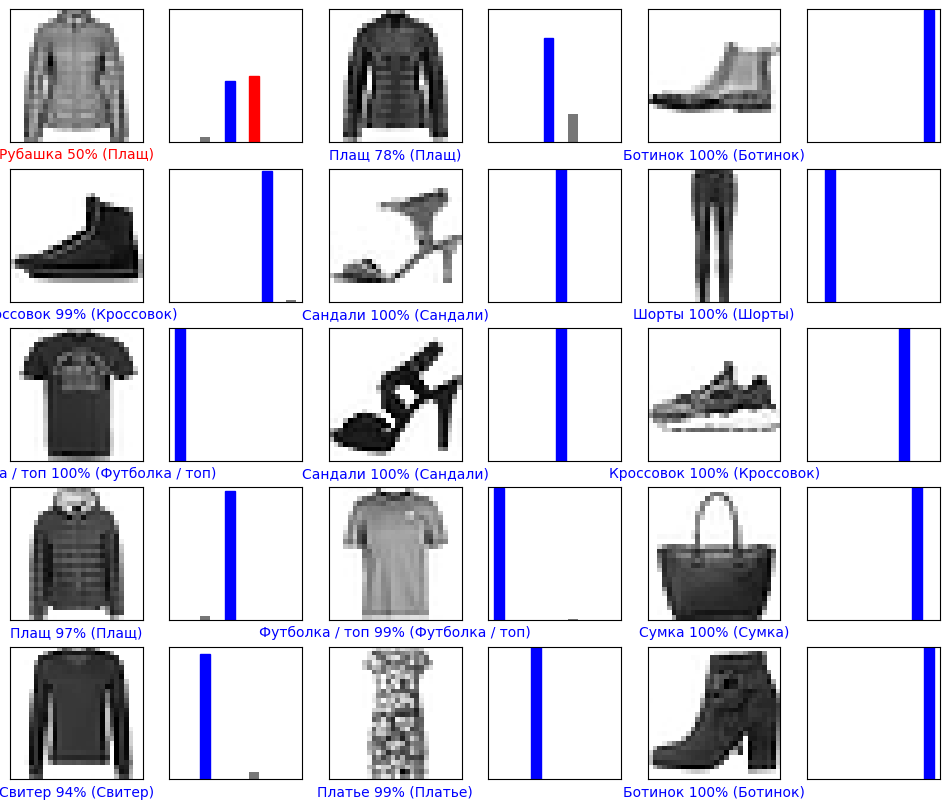

In [ ]:
num_rows = 5
num_cols = 3
num_images = num_rows * num_cols
plt.figure(figsize=(2*2*num_cols, 2*num_rows))
for i in range(num_images):
  plt.subplot(num_rows, 2*num_cols, 2*i + 1)
  plot_image(i, predictions, test_labels, test_images)
  plt.subplot(num_rows, 2*num_cols, 2*i + 2)
  plot_value_array(i, predictions, test_labels)

## Итог

Мы воспользовались набором данных Fashion MNIST, который содержит 70 000 изображений элементов одежды. 60 000 из которых использовали для тренировки нейронной сети, а остальные 10 000 для тестирования эффективности её работы. Для того чтобы подать на вход нашей нейронной сети эти изображения нам понадобилось преобразовать их (сгладить) из формата 2D размером 28х28 в формат 1D размером 784 элемента. Наша сеть состояла из полносвязного слоя из 128 нейронов и выходного слоя из 10 нейронов, соответствуя количеству меток (классов, категорий элементов одежды). Эти 10 выходных значений представляли собой распределение вероятностей для каждого класса. Функция активации softmax подсчитывала распределение вероятностей.